In [2]:
import torch,torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import numpy as np
from model import Generator, iterate_minibatches, compute_loss, train
from IPython import display
import matplotlib.pyplot as plt
from tqdm import tqdm
%matplotlib inline
import time
import torch.utils.data

/opt/miniconda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
OCTAVE_NUM = 4
NOTE_NUM = 12
TIME_SCALE = 128


class LSTM_discriminator(nn.Module):
    def __init__(self,hidden_size = 1000,last_dim = 3):
        super(self.__class__, self).__init__()
        self.last_dim = last_dim
        self.hidden_size = hidden_size
        self.note_lstm = nn.LSTM(input_size = OCTAVE_NUM*last_dim,hidden_size = hidden_size)
        self.time_lstm = nn.LSTM(input_size = hidden_size,hidden_size = hidden_size)
        self.dense = nn.Linear(hidden_size,1)

    def forward(self,data):
        # data.size() =  (batch_size, TIME_SCALE, NOTE_NUM*OCTAVE_NUM, last_dim)
        # octave_data.size() =  (batch_size, TIME_SCALE, NOTE_NUM,OCTAVE_NUM*last_dim)
        batch_size,_,_,_ = data.size()
        octave_data = data.view(batch_size,TIME_SCALE,NOTE_NUM,OCTAVE_NUM,self.last_dim)\
                          .view(batch_size,TIME_SCALE,NOTE_NUM,OCTAVE_NUM*self.last_dim)
            
        # note_lstm_input.size() = (NOTE_NUM, batch_size*TIME_SCALE,OCTAVE_NUM*last_dim)
        note_lstm_input = octave_data.view(batch_size*TIME_SCALE,NOTE_NUM,OCTAVE_NUM*self.last_dim)\
                                     .transpose(0,1)
        # note_lstm_output.size() = (NOTE_NUM,batch_size*TIME_SCALE,hidden_size)
        note_lstm_output, _ = self.note_lstm(note_lstm_input)
        # time_lstm_input.size() = (TIME_SCALE,batch_size,hidden_size)
        time_lstm_input = note_lstm_output[-1].view(batch_size,TIME_SCALE,self.hidden_size)\
                                          .transpose(0,1)\
        # time_lstm_output.size() = (TIME_SCALE,batch_size,1000)
        time_lstm_output, _  = self.time_lstm(time_lstm_input)
        # dense_input.size() = (batch_size,1000)
        dense_input = time_lstm_output[-1]
        # dense_output.size() = (batch_size,1)
        dense_output = self.dense(dense_input)
        probs = F.sigmoid(dense_output)
        return probs
        
        
        

In [4]:
class LSTM_baseline(nn.Module):
    def __init__(self,hidden_size = 1000):
        super(self.__class__, self).__init__()
        self.hidden_size = hidden_size
        self.note_lstm = nn.LSTM(input_size = OCTAVE_NUM*3,hidden_size = hidden_size)
        self.time_lstm = nn.LSTM(input_size = hidden_size,hidden_size = hidden_size)
        self.dense = nn.Linear(hidden_size,1)

    def forward(self,data,_):
        # data.size() =  (batch_size, TIME_SCALE, NOTE_NUM*OCTAVE_NUM, 3)
        # octave_data.size() =  (batch_size, TIME_SCALE, NOTE_NUM,OCTAVE_NUM*3)
        batch_size,_,_,_ = data.size()
        octave_data = data.view(batch_size,TIME_SCALE,NOTE_NUM,OCTAVE_NUM,3)\
                          .view(batch_size,TIME_SCALE,NOTE_NUM,OCTAVE_NUM*3)
            
        # note_lstm_input.size() = (NOTE_NUM, batch_size*TIME_SCALE,OCTAVE_NUM*3)
        note_lstm_input = octave_data.view(batch_size*TIME_SCALE,NOTE_NUM,OCTAVE_NUM*3)\
                                     .transpose(0,1)
        # note_lstm_output.size() = (NOTE_NUM,batch_size*TIME_SCALE,hidden_size)
        note_lstm_output, _ = self.note_lstm(note_lstm_input)
        # time_lstm_input.size() = (TIME_SCALE,batch_size,hidden_size)
        time_lstm_input = note_lstm_output[-1].view(batch_size,TIME_SCALE,self.hidden_size)\
                                          .transpose(0,1)\
        # time_lstm_output.size() = (TIME_SCALE,batch_size,1000)
        time_lstm_output, _  = self.time_lstm(time_lstm_input)
        # dense_input.size() = (batch_size,1000)
        dense_input = time_lstm_output[-1]
        # dense_output.size() = (batch_size,1)
        dense_output = self.dense(dense_input)
        probs = F.sigmoid(dense_output)
        return probs

In [5]:
class BasicGenerator(nn.Module):
    def __init__(self,hidden_size = 1000):
        super(self.__class__, self).__init__()
        self.dense_in = nn.Linear(TIME_SCALE*NOTE_NUM*OCTAVE_NUM*3,hidden_size)
        self.dense_out = nn.Linear(hidden_size,TIME_SCALE*NOTE_NUM*OCTAVE_NUM*3)

    def forward(self,data,_):
        batch_size,_,_,_ = data.size()
        data = data.view(batch_size,-1)
        hid_data = self.dense_in(data)
        out_data = self.dense_out(hid_data)
        output = F.sigmoid(out_data.view(batch_size, TIME_SCALE, NOTE_NUM*OCTAVE_NUM, 3))
        return output
        

In [6]:
class BasicDiscriminator(nn.Module):
    def __init__(self,hidden_size = 1000):
        super(self.__class__, self).__init__()
        self.dense_in = nn.Linear(TIME_SCALE*NOTE_NUM*OCTAVE_NUM*3,hidden_size)
        self.dense_out = nn.Linear(hidden_size,1)

    def forward(self,data):
        batch_size,_,_,_ = data.size()
        data = data.view(batch_size,-1)
        hid_data = self.dense_in(data)
        out_data = self.dense_out(hid_data)
        output = F.sigmoid(out_data)
        return output

In [7]:
def g_loss(p_fake,sound,in_probs,p_baseline, eps = 1e-8):
        
    probs = sound[:,:,:,:2]*in_probs[:,:,:,:2]\
            +(1-sound[:,:,:,:2])*(1-in_probs[:,:,:,:2])
        
    return -((probs+eps).log().sum(dim =-1).sum(dim =-1).sum(dim =-1)*(p_fake-p_baseline)).mean(), probs

def g_loss_monte_carlo(p_fakes,sounds,in_probs,p_baseline, eps = 1e-8):
    
    loss = 0
    for sound, p_fake in zip(sounds, p_fakes):
        probs = sound[:,:,:,:2]*in_probs[:,:,:,:2]\
                +(1-sound[:,:,:,:2])*(1-in_probs[:,:,:,:2])
        loss += -((probs+eps).log().sum(dim =-1).sum(dim =-1).sum(dim =-1)*(p_fake-p_baseline)).mean()
        
    return loss/5, probs

def d_loss(p_fake, p_true,eps = 1e-8):
    return -(1-p_fake+eps).log().mean()-(p_true+eps).log().mean()
    
def bl_loss(bl_pred,real_reward):
    return (bl_pred-real_reward).pow(2).mean()


In [8]:
import torch.utils.data

def sample_sound(data_gen):
    size = data_gen.size()
    rand = torch.rand(*size).cuda()
    sample = (rand<data_gen).type(torch.FloatTensor).cuda()
    sample[:,:,:,2] = 1
    return sample

In [9]:
from dataset import load_all
from constants import *

styles= [['data/Bach_fugas']]
train_data, train_labels = load_all(styles, BATCH_SIZE, TIME_SCALE)

In [10]:
X_tr = train_data[0][:]
y_tr = train_labels[0][:]
print(train_data[0].shape)

def iterate_minibatches(train_data, train_labels, batchsize):
    indices = np.random.permutation(np.arange(len(train_labels)))
    for start in range(0, len(indices), batchsize):
        ix = indices[start: start + batchsize]
        
        if cuda:      
            yield  Variable(torch.FloatTensor(train_data[ix])).cuda(), Variable(torch.FloatTensor(train_labels[ix])).cuda()
        else:
            yield Variable(torch.FloatTensor(train_data[ix])), Variable(torch.FloatTensor(train_labels[ix]))

(340, 128, 48, 3)


In [70]:
def train_discriminator(x_batch, ch_batch):

    d_losses = []
    prob_noise = []
    prob_human = []
    prop_machine = []


    # Optimize D 
    # machine generation
    data_gen = generator(x_batch,ch_batch)
    sound = sample_sound(data_gen).data          
    false_example = torch.cat([x_batch, sound],dim = -1)
    true_example = torch.cat([x_batch, ch_batch],dim = -1)
    p_true_example = discriminator(true_example)
    p_false_example = discriminator(false_example)
    loss = d_loss(p_false_example, p_true_example)
    d_optimizer.zero_grad()
    loss.backward()
    d_optimizer.step()
    d_losses.append(loss.data.cpu().numpy())

    prop_machine.append(p_false_example.mean().data.cpu().numpy())
    prob_human.append(p_true_example.mean().data.cpu().numpy())

    # rand_like ones_like            
    noise_example = torch.cat([x_batch, sample_sound(torch.rand_like(x_batch).cuda())],dim = -1)
    true_example = torch.cat([x_batch, ch_batch],dim = -1)
    p_true_example = discriminator(true_example)
    p_noise_example = discriminator(noise_example)
    loss = d_loss(p_noise_example, p_true_example)
    d_optimizer.zero_grad()
    loss.backward()
    d_optimizer.step()
    d_losses.append(loss.data.cpu().numpy())    
    prob_noise.append(p_noise_example.mean())
          
    return np.array(prob_human),np.array(prop_machine),np.array(d_losses)

In [71]:
def train_generator(x_batch, ch_batch):

    g_losses = []
    prop_machine = []
    prob_human = []
    prob_confidence = []
    prob_noise = []
    
    monte_carlo = True
        
    # baseline
    p_baseline = baseline(x_batch,ch_batch)

    #generator
    # monte carlo false example sampling
    data_gen = generator(x_batch,ch_batch)
    if monte_carlo:
        p_false_examples = []
        sounds = []

        for _ in range(5):                  
            sound = sample_sound(data_gen).data                 
            false_example = torch.cat([x_batch, sound],dim = -1)
            p_false_example = discriminator(false_example.detach())
            p_false_examples.append(p_false_example)
            sounds.append(sound)

    else:
        sound = sample_sound(data_gen).data                 
        false_example = torch.cat([x_batch, sound],dim = -1)
        p_false_example = discriminator(false_example.detach())


    true_example = torch.cat([x_batch, ch_batch],dim = -1)
    p_true_example = discriminator(true_example.detach())

    # Optimize G  

    handle = np.random.randint(0,2) #0 #np.random.randint(0,2)
    if handle == 0:
        if monte_carlo:
            loss, confidence = g_loss_monte_carlo(p_false_examples,
                      sounds,data_gen,p_baseline)
        else:
            loss, confidence = g_loss(p_false_example,
                      sound,data_gen,p_baseline)
    else:
        # teacher forcing
        # p_true_example
        loss, confidence = g_loss(1,
                      ch_batch,data_gen,p_baseline)

#             loss = g_loss(p_false_example, sound, data_gen, p_baseline)+compute_loss(data_gen, ch_batch)

    g_optimizer.zero_grad()
    loss.backward()
    g_optimizer.step()
    g_losses.append(loss.data.cpu().numpy())

    # history
    prob_human.append(p_true_example.mean().data.cpu().numpy())
    prop_machine.append(p_false_example.mean().data.cpu().numpy())
    prob_confidence.append(confidence.mean().data.cpu().numpy())
        

    return np.array(prob_human),np.array(prop_machine), np.array(prob_confidence), np.array(g_losses)
            
    

In [72]:
def train_baseline(x_batch, ch_batch):
    
    bl_losses = []
    prob_baseline = [] 
    prob_false_example = []

    # Optimize BL
    data_gen = generator(x_batch,ch_batch)
    sound = sample_sound(data_gen).data
    false_example = torch.cat([x_batch, sound],dim = -1)
    p_baseline = baseline(x_batch,ch_batch)
    p_false_example = discriminator(false_example.detach())
    loss = bl_loss(p_baseline, p_false_example)
    bl_optimizer.zero_grad()
    loss.backward()
    bl_optimizer.step()

    # history
    bl_losses.append(loss.data.cpu().numpy())
    prob_baseline.append(p_baseline.mean().data.cpu().numpy())
    prob_false_example.append(p_false_example.mean().data.cpu().numpy())

    return np.array(prob_baseline), np.array(bl_losses)
           
    

In [73]:
def plot_history(history):
    
    plt.figure(figsize=(16, 6))
    plt.title("losses")
    plt.subplot(231)
    plt.plot(history['g_losses'],label = "Generator loss")
    plt.legend()
    plt.subplot(232)
    plt.plot(history['d_losses'],label = "Discriminator loss")
    plt.legend(loc=2)
    plt.subplot(233)
    plt.plot(history['bl_losses'],label = "Baseline loss")
    plt.legend()
    plt.subplot(234)
    g_machine = np.asarray(history['prop_machine'].copy())
    d_machine = np.asarray(history['prop_machine'].copy())
    g_machine[np.asarray(history['color']) == 1] = np.nan
    d_machine[np.asarray(history['color']) == 0] = np.nan
    plt.plot(g_machine, 'o', label = "Machine P - generator", color = 'blue' )
    plt.plot(d_machine, 'o', label = "Machine P - discriminator", color = 'orange' )
    plt.plot(history['prob_human'], 'o', label = "Human P", color = 'green')
    plt.legend(loc=2)
    plt.subplot(235)
    plt.plot(history['prob_confidence'],label = "Machine confidence")
    plt.legend()
    plt.subplot(236)
    plt.plot(history['prop_baseline'],label = "Baseline probabilyty")
    plt.legend()
    plt.show()

def train_GAN(g_lr = 0.001, d_lr = 0.001, bl_lr = 0.001, n_epochs=3):
    
    history = {'d_losses':[],'g_losses':[],'bl_losses':[],'prop_machine':[0.,0,0],
               'prob_human':[1,1.,1],'prob_confidence':[1,],'prop_baseline':[], 'prob_noise':[], 'color':[0,0,0]}
    
    
#     p_human = np.array([1])
#     p_machine = np.array([1])
    it_generator = 0
    
    for epoch in range(n_epochs):

        start_time = time.time()
        dataset = iterate_minibatches(X_tr, y_tr, 16)
        for i, [x_batch,ch_batch] in tqdm(enumerate(dataset)):
            
            try:

                x_batch[:,:,:,2] = 1
                ch_batch[:,:,:,2] = 1

                p_baseline, bl_l = train_baseline(x_batch, ch_batch)
                history['prop_baseline'].extend(p_baseline)
                history['bl_losses'].extend(bl_l) 

                if (np.maximum(np.asarray(history['prob_human'][-3:])-np.asarray(history['prop_machine'][-3:]),0).mean()<0.1) \
                            or np.asarray(history['prob_human'][-3:]).mean()<0.9:

                    it_generator = 0
                    p_human, p_machine, d_l = train_discriminator(x_batch, ch_batch) 
    #                 print('D p_machine', p_machine, p_human)
                    history['d_losses'].extend(d_l)
                    history['prop_machine'].extend(p_machine)
                    history['prob_human'].extend(p_human)
                    history['color'].extend(np.ones(len(p_machine)))
                else: 
                    it_generator+=1
                    p_human, p_machine, p_confidence, g_l = train_generator(x_batch, ch_batch)
    #                 print('G p_machine', p_machine, p_human)
                    history['g_losses'].extend(g_l)
                    history['prop_machine'].extend(p_machine)
                    history['prob_human'].extend(p_human)  
                    history['prob_confidence'].extend(p_confidence)
                    history['color'].extend(np.zeros(len(p_machine)))
            except KeyboardInterrupt:
                return history


        # Visualize
        display.clear_output(wait=True)
#         plt.figure(figsize=(16, 6))

        # Then we print the results for this epoch:
        if history['color'][-1]==0:
            tr = 'generator trainig'
        else: tr = 'discriminator trainig'
        print("Epoch {} of {} took {:.3f}s, format {}".format(
            epoch, n_epochs, time.time() - start_time, tr))
        print('mean probability of machine generation: {}'.format(history['prop_machine'][-1]))
        print('mean probability of human generation: {}'.format(history['prob_human'][-1]))
    #         print('mean probability of noise generation: {}'.format(prob_noise[-1]))
        print('mean probability of machine generation confidence: {}'.format(history['prob_confidence'][-1]))

        plot_history(history)

            
    return history

In [74]:
discriminator = LSTM_discriminator(hidden_size=500, last_dim=6).cuda()
generator = Generator().cuda()
# generator.load_state_dict(torch.load(os.path.join(OUT_DIR, 'model_canonical')))
baseline = LSTM_baseline(hidden_size=40).cuda()
# generator.load_state_dict(torch.load(os.path.join(OUT_DIR, 'model_canonical')))
generator.load_state_dict(torch.load(os.path.join(OUT_DIR, 'model_canonical_attention'))) 
discriminator.load_state_dict(torch.load(os.path.join(OUT_DIR, 'pretrained_discriminator')))
# generator.load_state_dict(torch.load(os.path.join(OUT_DIR, 'generator_rl')))

In [75]:
# discriminator.load_state_dict(torch.load(os.path.join(OUT_DIR, 'pretrained_discriminator')))

In [76]:
# dataset = iterate_minibatches(X_tr, y_tr, 1)

# x_batch, ch_batch = next(dataset)

In [77]:
# x_batch, ch_batch = next(dataset)
# x_batch[:,:,:,2] = 1
# ch_batch[:,:,:,2] = 1

# p_human, p_machine, d_l = \
#                     train_discriminator(x_batch, ch_batch) 
# print(p_machine)
# print(p_human)
# # x_batch, ch_batch = next(dataset)

# p_human, p_machine, p_confidence, g_l = \
#                     train_generator(x_batch, ch_batch)
# print()
# print(p_machine)
# print(p_human)

In [78]:
# dataset = iterate_minibatches(X_tr, y_tr, 16)
# for x_batch, ch_batch in dataset:
#     x_batch[:,:,:,2] = 1
#     ch_batch[:,:,:,2] = 1
#     p_human, p_machine, p_confidence, g_l = \
#                         train_generator(x_batch, ch_batch)
#     print(p_machine)
#     print(p_human)

Epoch 8 of 200 took 7.559s, format discriminator trainig
mean probability of machine generation: 0.6689724922180176
mean probability of human generation: 0.6691136956214905
mean probability of machine generation confidence: 0.9392793774604797


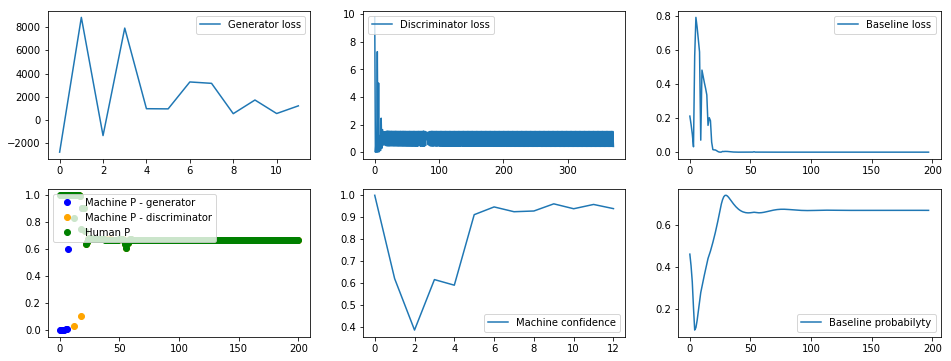

6it [00:02,  2.90it/s]


In [79]:
g_lr = 1e-3
d_lr = 1e-3
bl_lr = 1e-2
generator.train()
d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=d_lr, betas=(0.5, 0.999)) #, weight_decay = 1, betas=(0.5, 0.999)) 
bl_optimizer = torch.optim.Adam(baseline.parameters(),  lr=bl_lr)
g_optimizer = torch.optim.Adam(generator.parameters(),  lr=g_lr)#, betas=(0.5, 0.999))

history = train_GAN(g_lr = 1e-3,d_lr=1e-3, bl_lr = 1e-2, n_epochs=200)

In [83]:
# plot_history(history)

In [81]:
torch.save(generator.state_dict(), os.path.join(OUT_DIR, 'generator_rl'))
torch.save(discriminator.state_dict(), os.path.join(OUT_DIR, 'discriminator'))
torch.save(baseline.state_dict(), os.path.join(OUT_DIR, 'baseline'))

In [29]:
torch.cuda.empty_cache()

In [80]:
from generate import write_file, generate

# torch.cuda.empty_cache()


# with torch.cuda.device(GPU):
write_file('output/rl_test', generate(generator, 16))

  0%|          | 1/256 [00:00<00:44,  5.69it/s]

Generating with no styles:


100%|██████████| 256/256 [00:24<00:00, 10.40it/s]

Writing file out/samples/output/rl_test_0.mid
